# Boosting
## Alto bias - Underfitting
- Se entrenan los modelos de manera secuencial, no paralelo como Bagging
- Bootstraping con modelos de alto Bias y baja Varianza
- Se distinguen las predicciones dificiles y se pesan para que el siguiente predictor focalice en ellas
- Al final cada modelo se pesa de manera diferente

In [500]:
%load_ext autoreload
%autoreload 2
import reg_helper as RHelper
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [501]:
folder = 'data/'
X_train = np.load(folder+'X_train.npy')
X_test = np.load(folder+'X_test.npy')
y_train = np.load(folder+'y_train.npy') 
y_test = np.load(folder+'y_test.npy')

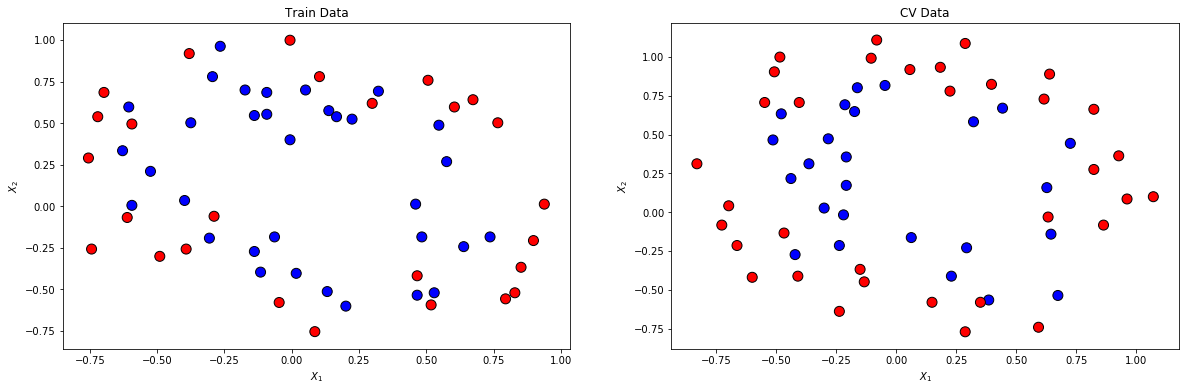

In [502]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, ax=ax1)
RHelper.plot_boundaries(X_test, y_test, ax=ax2)
ax1.set_title('Train Data')
ax2.set_title('CV Data')
ax1.set_xlabel('$X_1$')
ax1.set_ylabel('$X_2$')
ax2.set_xlabel('$X_1$')
ax2.set_ylabel('$X_2$')
plt.show()

# AdaBoostClassifier
https://www.youtube.com/watch?v=LsK-xG1cLYA
- Se suelen usar stumps (Forest of stumps) - week learners
- La diferencia con Random forests es el peso con el que se suman y que es secuencial (Ya que se pesan por el error)
- Stump: Un nodo y dos hojas
- Se pesan los errores para que en el bootstrapping tengan mas probabilidad de salir
- El peso del predictor al final es 'proporcional' a la mejora

https://xavierbourretsicotte.github.io/AdaBoost.html

In [1022]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [1045]:
n_estimators = 10
alg = 'SAMME.R'
base_clf = DecisionTreeClassifier(max_depth=1, criterion='entropy')

boost_clf = AdaBoostClassifier(base_clf, n_estimators=n_estimators, algorithm=alg, 
                               random_state=42, learning_rate=1.0)

In [1046]:
boost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

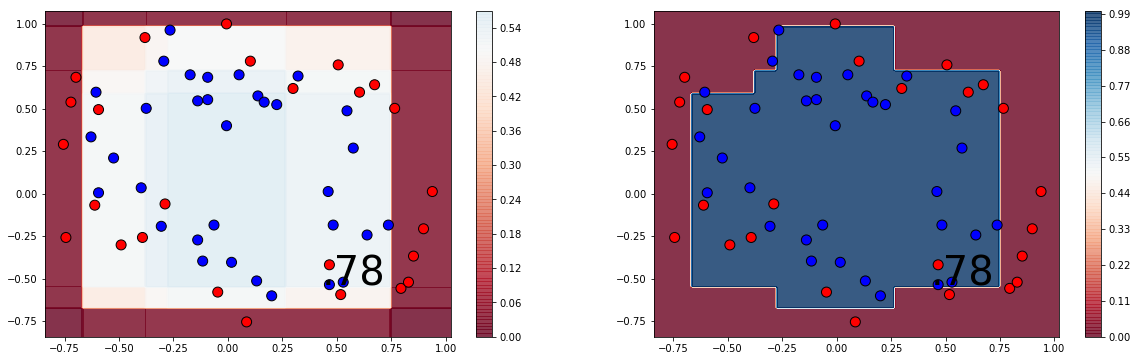

In [1047]:
score_train = boost_clf.score(X_train, y_train)
# Graficamos probabilidades en el plano de la combinación de todos los clasificadores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, score_train, boost_clf.predict_proba,  mesh_res=200, ax=ax1, bound_line=False)
RHelper.plot_boundaries(X_train, y_train, score_train, boost_clf.predict,  mesh_res=200, ax=ax2, bound_line=False)

In [997]:
def _samme_proba(estimator, X):
    proba = estimator.predict_proba(X)
    np.clip(proba, np.finfo(proba.dtype).eps, None, out=proba)
    log_proba = np.log(proba)
    samme_proba = log_proba - 0.5 * log_proba.sum(axis=1)[:, np.newaxis]
    return samme_proba

In [993]:
def samme_to_final(samme_proba):
    samme_proba = samme_proba.copy()
    samme_proba[:, 0] *= -1
    return samme_proba.sum(axis=1)

In [981]:
weights = boost_clf.estimator_weights_
print(weights)

[0.44802472 0.0724955  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [982]:
classes = boost_clf.classes_[:, np.newaxis]
classes

array([[0.],
       [1.]])

In [983]:
pred = 0
for i in range(len(boost_clf.estimators_)):
    if alg == 'SAMME.R':
        pred = pred + _samme_proba(boost_clf.estimators_[i],  X_train)*weights[i]
    else:
        pred = pred + (boost_clf.estimators_[i].predict(X_train) == classes).T * weights[i]

In [984]:
# pred

In [985]:
print(samme_to_final(pred)[:10]/sum(weights))

[ 0.72144982  0.72144982  0.72144982  0.72144982  0.72144982  0.72144982
 -1.          0.72144982  0.72144982 -1.        ]


In [986]:
print(boost_clf.decision_function(X_train)[:10])

[ 0.72144982  0.72144982  0.72144982  0.72144982  0.72144982  0.72144982
 -1.          0.72144982  0.72144982 -1.        ]


In [987]:
def predict(boost_clf, y_train, X):
    N = len(boost_clf.estimators_)
    counts = np.zeros((len(X), len(boost_clf.classes_)))
    for i in range(N):
        stump_model = boost_clf.estimators_[i]
        pred = stump_model.predict(X)
        # print(pred)
        counts[pred==0, 0] = counts[pred==0, 0] + 1
        counts[pred==1, 1] = counts[pred==1, 1] + 1
    return 1*(counts[:, 0] >= counts[:, 1])

In [988]:
predict(boost_clf, y_train, [[-0.75, 0], [0.9,0.9], [0,0], [0.25, 1]])

array([1, 1, 1, 1])

In [510]:
boost_clf.predict_proba([[-0.75, 0], [0.9,0.9], [0,0], [0.25, 1]])[:,1]

array([1.54512769e-04, 9.56189263e-05, 5.72392675e-01, 4.70300754e-01])

In [511]:
boost_clf.predict([[-0.75, 0], [0.9,0.9], [0,0], [0.25, 1]])

array([0., 0., 1., 0.])

In [512]:
print(boost_clf.estimator_errors_)

[0.33898305 0.4        0.40530303 0.40505277]


In [513]:
print(boost_clf.estimator_weights_)

[1. 1. 1. 1.]


In [514]:
from functools import partial

In [515]:
y_train

array([0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1.])

In [497]:
def predict_proba(boost_clf, y_train, X):
    y_train = y_train*2 -1
    y_sum = 0
    N = len(boost_clf.estimators_)
    ws = np.array([1/len(X)]*len(X)).reshape(len(X), 1)
    for i in range(N):
        stump_model = boost_clf.estimators_[i]
        est_err = boost_clf.estimator_errors_[i]
        alpha = 0.5*np.log((1-est_err)/est_err)
        pred = stump_model.predict(X)*2 - 1
        est_err_calc = (y_train != pred).T.dot(ws)
        #print(np.exp(-alpha*y_train*pred))
        ws = ws*np.exp(-alpha*y_train*pred).reshape(-1,1)
        ws = ws/np.sum(ws)
        print(est_err_calc, est_err)
        y_sum = y_sum + alpha*pred
    return y_sum

def predict(boost_clf, y_train, X):
    return ((predict_proba(boost_clf, X))>=0)*1

In [498]:
predict_proba(boost_clf, y_train, X_train) # [:,1]

[0.33898305] 0.3389830508474577
[0.47692308] 0.40000000104404837


array([ 0.53664724,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
        0.53664724,  0.53664724,  0.53664724,  0.53664724, -0.13118213,
        0.53664724,  0.53664724,  0.53664724, -0.13118213,  0.53664724,
        0.53664724,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
        0.53664724,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
        0.53664724,  0.53664724,  0.53664724,  0.53664724,  0.13118213,
        0.53664724,  0.13118213,  0.53664724,  0.13118213, -0.13118213,
        0.53664724,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
        0.13118213,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
        0.53664724, -0.13118213,  0.53664724,  0.53664724,  0.53664724,
       -0.13118213,  0.53664724,  0.53664724,  0.53664724,  0.53664724,
       -0.13118213,  0.53664724,  0.53664724,  0.53664724])

0.3389830508474577 0.667829372575655
0.3389830508474577 0.667829372575655


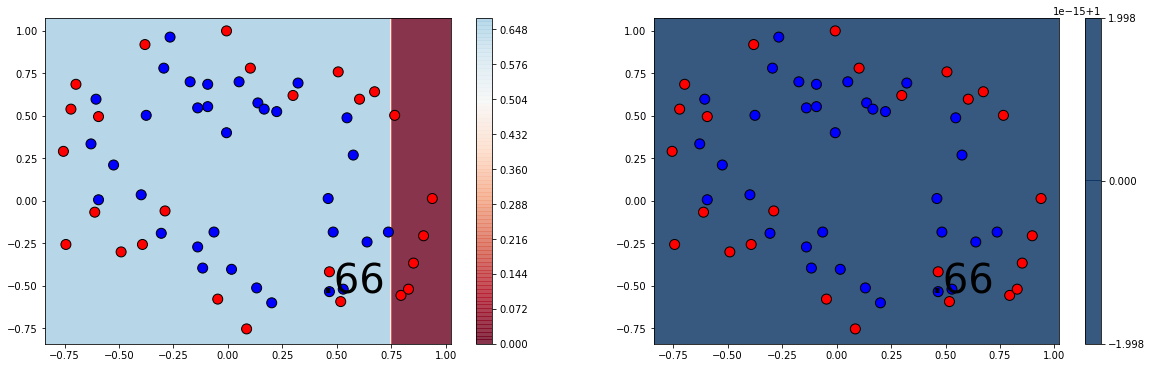

In [355]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, score_train, partial(predict_proba, boost_clf),  mesh_res=200, ax=ax1, bound_line=False)
RHelper.plot_boundaries(X_train, y_train, score_train, partial(predict, boost_clf),  mesh_res=200, ax=ax2, bound_line=False)

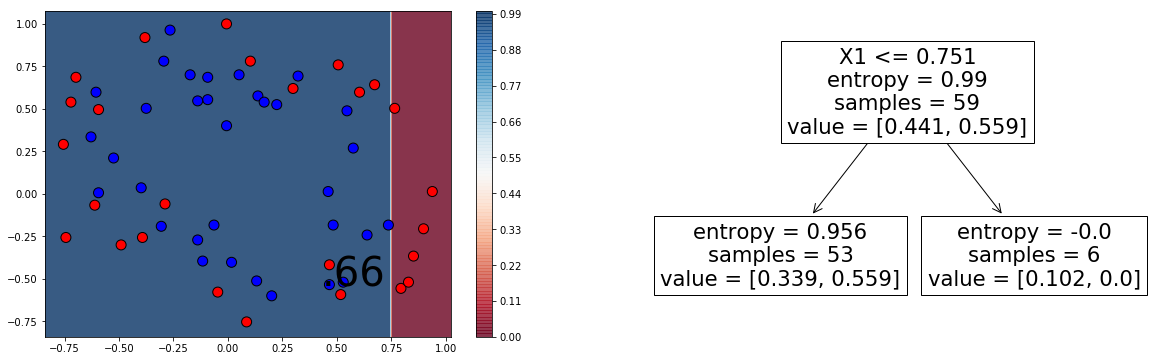

In [368]:
for i in range(len(boost_clf.estimators_)):
    stump_model = boost_clf.estimators_[i]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    RHelper.plot_boundaries(X_train, y_train, score_train, stump_model.predict,  mesh_res=200, ax=ax1, bound_line=False)
    plot_tree(stump_model, ax=ax2, feature_names=['X1','X2'])
    plt.show()

In [28]:
boost_clf.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

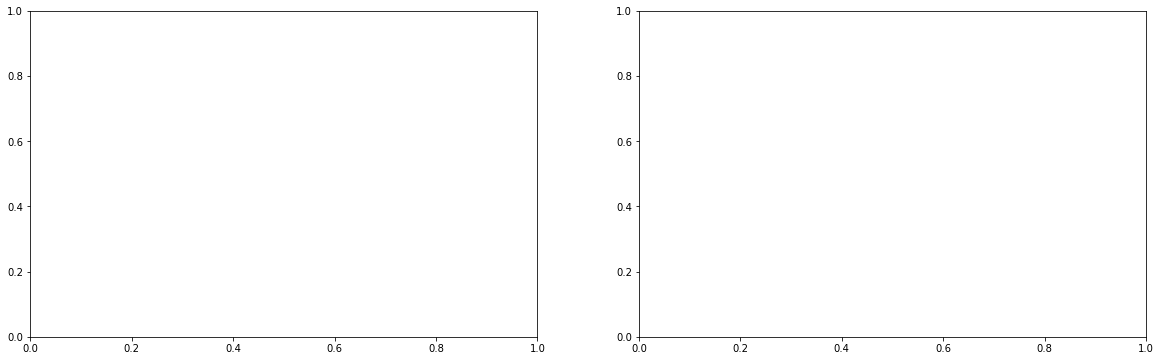

In [29]:
for i, stage_predictiton in enumerate(boost_clf.staged_predict_proba(X_train)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    RHelper.plot_boundaries(X_train, y_train, score_train, stage_predictiton.predict,  mesh_res=200, ax=ax1, bound_line=False)
    RHelper.plot_boundaries(X_test, y_test, score_test, stage_predictiton.predict,  mesh_res=200, ax=ax2, bound_line=False)

# GradientBoostingClassifier

https://www.youtube.com/watch?v=3CC4N4z3GJc

- El primero suele ser un stump, pero luego suelen ser mas grandes que un stump
- Se agrega learning rate para evitar el overfitting (Cuando se hace la suma para hacer la predicción se multiplica por este que esta entre 0 y 1)
- Cada arbol nuevo busca estimar el error de las estimaciones con la suma de todos los arboles anteriores (secuencial) (Multiplicados por el learning rate)

In [101]:
n_estimators = 100
learning_rate = 0.1 # 1.0, 0.001
GBC_clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=2, random_state=1, learning_rate=learning_rate)
GBC_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

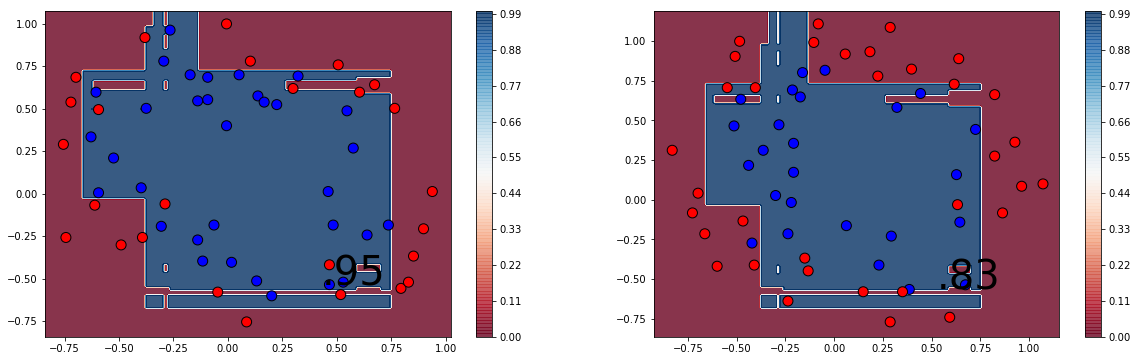

In [102]:
score_train = GBC_clf.score(X_train, y_train)
score_test = GBC_clf.score(X_test, y_test)
# Graficamos probabilidades en el plano de la combinación de todos los clasificadores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, score_train, GBC_clf.predict,  mesh_res=200, ax=ax1, bound_line=False)
RHelper.plot_boundaries(X_test, y_test, score_test, GBC_clf.predict,  mesh_res=200, ax=ax2, bound_line=False)

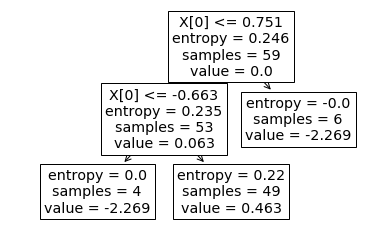

In [103]:
_=plot_tree(GBC_clf.estimators_[0][0])